In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

import scipy
from scipy import spatial

In [31]:
import seaborn as sns
sns.set_style(
    #style='darkgrid', 
    sns.axes_style("white")
    #rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 80

### Hyperparameters initialisation:

In [3]:
#dimension of the vector beta_i: it has p features we want to learn. Here p=beta_dim
beta_dim =100

In [4]:
#The input x is a scalar and here its dimension is 1
input_dim = 1

In [5]:
#number of rbf centers
num_phi_rbf = 100

#sigma of the radial basis function
phi_rbf_sigma =5.0 

#we need to learn phi using a NN. We assume it has 2 hidden layers, each with 10 neurons
phi_hidden_layer_size = 20

In [6]:
#dimension of the latent variable z that embeds beta
z_dim = 20

In [7]:
# Gives the numbers of betas to learn
num_training_funcs = 1000

In [8]:
#each function f_i is evaluated at K locations. Here K=num_eval_points
#this is the K in the piVAE paper: number of locations where we evaluate each fct/each path:
K = 80

In [9]:
#the encoder and the decoder parts each have 3 layers
encoder_h_dim_1 = 512
encoder_h_dim_2 = 512
encoder_h_dim_3 = 128

decoder_h_dim_1 = 128
decoder_h_dim_2 = 128
decoder_h_dim_3 = 128

In [10]:
s_lims =[-5.0, 5.0]

In [11]:
#Define the exponential kernel: l is the lengthscale parameter. 
def exponential_kernel(t_i, t_j, l, sigma_f):    
    dist = scipy.spatial.distance.cdist(t_i, t_j, 'euclidean')
    
    return sigma_f**2 * np.exp(-0.5 / l**2 * dist)

In [12]:
lengthscale=1.0
sigma_f=1.0

In [13]:
def generate_OU_dataset_with_kernel(lengthscale, sigma_f):
    
    locations_append=[]
    OU_samples_append=[]
    
    for fct_id in range(num_training_funcs):
        #print("fct_id:")
        #print(fct_id)
        
        locations = np.random.uniform(s_lims[0], s_lims[1],size=(K,1))  
        #compute correlation matrix between those K locations
        cov = exponential_kernel(locations, locations, lengthscale, sigma_f)
        #cov.shape
        
        mu = np.zeros(locations.shape)
        
        OU_sample = np.random.multivariate_normal(mu.ravel(), cov, 1)        
            
        locations_append.append(locations)
        OU_samples_append.append(OU_sample)
        
    
    return np.array(locations_append), np.array(OU_samples_append)
    

In [14]:
dataset_locations, dataset_OU=generate_OU_dataset_with_kernel(lengthscale, sigma_f)

In [15]:
dataset_locations.shape

(1000, 80, 1)

In [16]:
dataset_OU.shape

(1000, 1, 80)

In [17]:
dataset_loc_training=dataset_locations[:1000,:,:]
dataset_OU_training=dataset_OU[:1000,:,:]

In [18]:
#dataset_loc_test=dataset_locations[1500:,:,:]
#dataset_OU_test=dataset_OU[1500:,:,:]

In [19]:
#dataset_loc_training.shape
dataset_OU_training.shape

(1000, 1, 80)

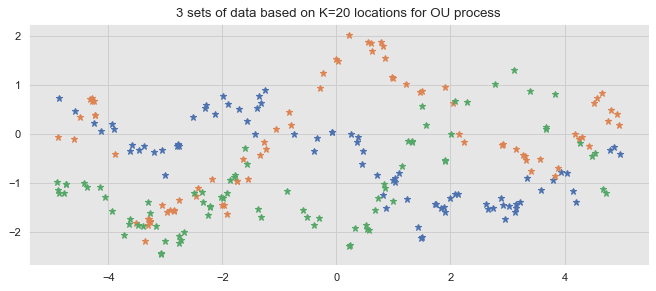

In [20]:
for i in range(3):
    plt.plot(dataset_locations[i,:,0],dataset_OU[i,0,:], "*")
plt.title("3 sets of data based on K=20 locations for OU process")
plt.show()

In [21]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()                                  
    
        self.phi_rbf_centers = nn.Parameter(torch.tensor(
            np.random.uniform(s_lims[0], s_lims[1],
            size=(num_phi_rbf, input_dim))))
        self.phi_nn_1 = nn.Linear(num_phi_rbf, phi_hidden_layer_size)
        self.phi_nn_2 = nn.Linear(phi_hidden_layer_size, beta_dim)

        self.encoder_nn_1 = nn.Linear(beta_dim, encoder_h_dim_1)
        self.encoder_nn_2 = nn.Linear(encoder_h_dim_1, encoder_h_dim_2)
        self.encoder_nn_3 = nn.Linear(encoder_h_dim_2, encoder_h_dim_3)
        self.encoder_nn_4 = nn.Linear(encoder_h_dim_3, z_dim * 2)

        self.decoder_nn_1 = nn.Linear(z_dim, decoder_h_dim_1)
        self.decoder_nn_2 = nn.Linear(decoder_h_dim_1, decoder_h_dim_2)
        self.decoder_nn_3 = nn.Linear(decoder_h_dim_2, decoder_h_dim_3)
        self.decoder_nn_4 = nn.Linear(decoder_h_dim_3, beta_dim)

        # self.betas = nn.Parameter(torch.ones(num_training_funcs, beta_dim))
        self.betas = nn.Parameter(torch.tensor(
            np.random.uniform(-0.1, 0.1, size=(num_training_funcs, beta_dim))
        ))

        self.normal_sampler = torch.distributions.normal.Normal(0.0, 1.0)


    def Phi(self, input):
        #print('input size')
        #print(input.shape)
        
        input_expand = torch.unsqueeze(input, 1)
        #print('input_expand size')
        #print(input_expand.shape)
        
        #print('self.phi_rbf_centers size')
        #print(self.phi_rbf_centers.shape)
        
        phi_expand = torch.unsqueeze(self.phi_rbf_centers, 0)
        #print('phi_expand size')
        #print(phi_expand.shape)
        M1 = input_expand - phi_expand
        M2 = torch.sum(M1 ** 2, 2)

        M3 = torch.exp(-M2/phi_rbf_sigma)
        M4 = F.sigmoid(self.phi_nn_1(M3))
        M5 = self.phi_nn_2(M4)
        return M5
     

    def encoder(self, input):
        
        # input (batch x beta_dim) output ((batch x z_dim), (batch x z_dim))
        M1 = F.relu(self.encoder_nn_1(input))
        M2 = F.relu(self.encoder_nn_2(M1))
        M3 = F.relu(self.encoder_nn_3(M2))
        M4 = self.encoder_nn_4(M3)
        z_mean = M4[:, 0:z_dim]
        z_std = torch.exp(M4[:, z_dim:]) # needs to be positive
        return z_mean, z_std

    def decoder(self, input):
        # input (batch x z_dim) output (batch x beta_dim)
        M1 = F.relu(self.decoder_nn_1(input))
        M2 = F.relu(self.decoder_nn_2(M1))
        M3 = F.relu(self.decoder_nn_3(M2))
        M4 = self.decoder_nn_4(M3)
        return M4
    
    
    

    def get_loss_term_1(self, fct_id, s, x):
        batch_size = s.shape[0]
        phi_s = self.Phi(s)        
        original_beta_fct_id = self.betas[fct_id, :]        
        x_enc = torch.matmul(phi_s, original_beta_fct_id)                
        loss_term_1 = (x - x_enc)**2
        
        return torch.mean(loss_term_1)

       
    def get_loss_term_2(self, fct_id, s, x): 
        phi_s = self.Phi(s)    
        original_beta_fct_id = self.betas[fct_id, :]        
        z_mean, z_std = self.encoder(original_beta_fct_id.unsqueeze(0))       
        z_sample = z_mean.double() + z_std.double() * self.normal_sampler.rsample((1, z_dim)).double()                    
        beta_hat = self.decoder(z_sample)        
        x_dec = torch.matmul(phi_s, beta_hat.squeeze())         
        loss_term_2 = (x - x_dec)**2
        
        return torch.mean(loss_term_2)

    
    def get_loss_term_3(self, fct_id, kl_factor):        
        original_beta_fct_id = self.betas[fct_id, :]  
        z_mean, z_std = self.encoder(original_beta_fct_id.unsqueeze(0))    
        loss_term_3 = 0.5 * torch.sum(z_std**2 + z_mean**2 - 1 - torch.log(z_std**2),dim=1)       
        loss_term_3 = kl_factor * (loss_term_3/z_dim)
        return loss_term_3       
        

   
    def get_loss(self, function_id, s, x, kl_factor, print_breakdown=False, 
        return_breakdown=False):
        batch_size = s.shape[0]

        phi_s = self.Phi(s)
        beta = self.betas[function_id, :]
        x_enc = torch.matmul(phi_s, beta)

        loss_term_1 = (x - x_enc)**2

        z_mean, z_std = self.encoder(beta.unsqueeze(0))
        z_sample = z_mean + z_std * self.normal_sampler.rsample((1, z_dim))
        beta_hat = self.decoder(z_sample)
        x_dec = torch.matmul(phi_s, beta_hat.squeeze()) 
        loss_term_2 = (x - x_dec)**2

     
        loss_term_3 = 0.5 * torch.sum(z_std**2 + z_mean**2 - 1 - torch.log(z_std**2),
            dim=1)
        loss_term_3 = kl_factor * (loss_term_3/z_dim)

        if print_breakdown:
            print("1", torch.mean(loss_term_1))
            print("2", torch.mean(loss_term_2))
            print("3", loss_term_3)

        if return_breakdown == False:
            return torch.mean(loss_term_1 + loss_term_2) + loss_term_3
        else:
            return torch.mean(loss_term_1 + loss_term_2) + loss_term_3, \
                torch.mean(loss_term_1), torch.mean(loss_term_2), loss_term_3

    
    # Compute decoded OU values at location points s
    # when the value of the latent variable z is given by the posterior
    def evaluate_decoded_x_at_given_z(self, z, s, return_beta_hat=False):        
        phi_s = self.Phi(s)       
        beta_hat = self.decoder(z)        
        x_dec = torch.matmul(phi_s, beta_hat)        
        if not return_beta_hat:
            return x_dec
        else:
            return x_dec, beta_hat
   

    # This function returns decoded values of x when z ~N(0,1). 
    # Generate samples from the pivae, with z ~ N(0,1)
    def generate_x_samples_from_pivae(self, s, num_samples):               
        z_samples = self.normal_sampler.rsample((num_samples, z_dim)).double()        
        beta_hats = self.decoder(z_samples)
        phi_s = self.Phi(s)
        x_dec = torch.matmul(beta_hats.unsqueeze(1).unsqueeze(1),
            phi_s.unsqueeze(2).unsqueeze(0))
        x_dec = x_dec.squeeze()

        return x_dec

In [22]:
pivae_model=Model().double()
pivae_model

Model(
  (phi_nn_1): Linear(in_features=100, out_features=20, bias=True)
  (phi_nn_2): Linear(in_features=20, out_features=100, bias=True)
  (encoder_nn_1): Linear(in_features=100, out_features=512, bias=True)
  (encoder_nn_2): Linear(in_features=512, out_features=512, bias=True)
  (encoder_nn_3): Linear(in_features=512, out_features=128, bias=True)
  (encoder_nn_4): Linear(in_features=128, out_features=40, bias=True)
  (decoder_nn_1): Linear(in_features=20, out_features=128, bias=True)
  (decoder_nn_2): Linear(in_features=128, out_features=128, bias=True)
  (decoder_nn_3): Linear(in_features=128, out_features=128, bias=True)
  (decoder_nn_4): Linear(in_features=128, out_features=100, bias=True)
)

In [27]:
#KL divergence factor: 
kl_factor=1.0

#learning rate
learning_rate=0.001

#this is the number of input functions used in training
num_funcs_to_consider = 1
current_max = 1000
interval = 3

total_nbr_epochs=300

In [28]:
optimizer=torch.optim.Adam(pivae_model.parameters(), lr=learning_rate)

In [29]:
Loss_per_epoch_append = []
L1_per_epoch_append = []
L2_per_epoch_append = []
L3_per_epoch_append = []

In [30]:
for epoch_id in range(total_nbr_epochs):
    
    print("epoch id:", epoch_id)
    l1s = []
    l2s = []
    l3s = []
    losses=[]
    

    
    for function_id in range(num_funcs_to_consider):
        optimizer.zero_grad()
        input_points = torch.tensor(dataset_loc_training[function_id])
        x_vals = torch.tensor(dataset_OU_training[function_id])
        loss, l1, l2, l3 = pivae_model.get_loss(function_id, input_points, x_vals,
            kl_factor, return_breakdown=True)
        loss.backward()
        optimizer.step()
        l1s.append(l1.detach().cpu().numpy())
        l2s.append(l2.detach().cpu().numpy())
        l3s.append(l3.detach().cpu().numpy())
        losses.append(loss.detach().cpu().numpy())

    if epoch_id % interval == 0:
        num_funcs_to_consider = min(num_funcs_to_consider+10, current_max)
        
    L1=np.mean(np.array(l1s))
    L2= np.mean(np.array(l2s))
    L3=np.mean(np.array(l3s))
    Loss=np.mean(np.array(losses))
       

    print("L1", L1,
        "L2", L2,
        "L3", L3,
        "Loss", Loss,
        "num funcs", num_funcs_to_consider)
    
    Loss_per_epoch_append.append(Loss)
    L1_per_epoch_append.append(L1)
    L2_per_epoch_append.append(L2)
    L3_per_epoch_append.append(L3)

print("Loss_per_epoch_append:")
print(Loss_per_epoch_append)

print("L1_per_epoch_append")
print(L1_per_epoch_append)

print("L2_per_epoch_append")
print(L2_per_epoch_append)

print("L3_per_epoch_append")
print(L3_per_epoch_append)


    

epoch id: 0
L1 0.6096705963025197 L2 0.6171147143694746 L3 0.008075620560446917 Loss 1.2348609312324412 num funcs 11
epoch id: 1
L1 0.9970161326487872 L2 1.4256110927599366 L3 0.006486935972718583 Loss 2.4291141613814426 num funcs 11
epoch id: 2
L1 0.8974383264810171 L2 1.2254699683974772 L3 0.003303585069931082 Loss 2.1262118799484253 num funcs 11
epoch id: 3
L1 0.8324763379120771 L2 1.1954171275914718 L3 0.0031009338777612428 Loss 2.03099439938131 num funcs 21
epoch id: 4
L1 1.0844013134944934 L2 1.2683889802969888 L3 0.0029474575007953064 Loss 2.3557377512922772 num funcs 21
epoch id: 5
L1 0.9400100572135818 L2 1.3353888849534936 L3 0.0027285370634458814 Loss 2.278127479230521 num funcs 21
epoch id: 6
L1 0.8358709754760189 L2 1.2931402470416968 L3 0.0024098279042865226 Loss 2.131421050422002 num funcs 31
epoch id: 7
L1 0.7601430273296986 L2 1.053319275053985 L3 0.0032580470197450403 Loss 1.8167203494034285 num funcs 31
epoch id: 8
L1 0.6483660458391084 L2 1.1862961232105464 L3 0.004

L1 0.19727283632264314 L2 0.7030307230262993 L3 0.06383665381134673 Loss 0.9641402131602891 num funcs 241
epoch id: 71
L1 0.16825855368150203 L2 0.7161258440172478 L3 0.06490726748310394 Loss 0.9492916651818538 num funcs 241
epoch id: 72
L1 0.15733576500134927 L2 0.6882449536988414 L3 0.05846848215476451 Loss 0.9040492008549551 num funcs 251
epoch id: 73
L1 0.18154611373011587 L2 0.7074403303840364 L3 0.06202473758006978 Loss 0.9510111816942223 num funcs 251
epoch id: 74
L1 0.16103686970450842 L2 0.7050135864603035 L3 0.06384638069249655 Loss 0.9298968368573084 num funcs 251
epoch id: 75
L1 0.15386863339046963 L2 0.691033534696009 L3 0.06618737852538603 Loss 0.9110895466118647 num funcs 261
epoch id: 76
L1 0.18256170981811412 L2 0.7013093604104638 L3 0.06692266613454992 Loss 0.9507937363631278 num funcs 261
epoch id: 77
L1 0.15812196887496482 L2 0.6976655412111717 L3 0.07106631605450597 Loss 0.9268538261406425 num funcs 261
epoch id: 78
L1 0.1502774185477336 L2 0.702579154543513 L3 0.0

L1 0.12650115643926915 L2 0.5835125036572227 L3 0.11433107765262086 Loss 0.8243447377491128 num funcs 471
epoch id: 140
L1 0.11625094283425084 L2 0.5778825873064155 L3 0.11518594097559486 Loss 0.8093194711162613 num funcs 471
epoch id: 141
L1 0.10746976907256488 L2 0.5649468434666197 L3 0.11194797758534952 Loss 0.7843645901245341 num funcs 481
epoch id: 142
L1 0.11881410339264847 L2 0.5706225536703126 L3 0.11339651622991734 Loss 0.8028331732928783 num funcs 481
epoch id: 143
L1 0.10625937140142709 L2 0.5659507219146789 L3 0.11563916308315325 Loss 0.7878492563992592 num funcs 481
epoch id: 144
L1 0.10270990834920189 L2 0.5657076554329014 L3 0.118681544361883 Loss 0.7870991081439862 num funcs 491
epoch id: 145
L1 0.11078013999174001 L2 0.5665527581653964 L3 0.11518763551094294 Loss 0.7925205336680795 num funcs 491
epoch id: 146
L1 0.1008703274239132 L2 0.5540862716519429 L3 0.11781451008998316 Loss 0.7727711091658392 num funcs 491
epoch id: 147
L1 0.09741634582623052 L2 0.552562988273820

L1 0.094219448387005 L2 0.5271934433099448 L3 0.13070379185200706 Loss 0.7521166835489568 num funcs 701
epoch id: 209
L1 0.09018597693912989 L2 0.5171445345227245 L3 0.1275738566866093 Loss 0.7349043681484636 num funcs 701
epoch id: 210
L1 0.08559995988660958 L2 0.5237703943742539 L3 0.1242498296232232 Loss 0.7336201838840868 num funcs 711
epoch id: 211
L1 0.09992965730863819 L2 0.5271179102004928 L3 0.12763438196286817 Loss 0.7546819494719991 num funcs 711
epoch id: 212
L1 0.09088427353256243 L2 0.5269887351801024 L3 0.12701702866167414 Loss 0.744890037374339 num funcs 711
epoch id: 213
L1 0.08787406194177205 L2 0.5177310781527134 L3 0.12937496610475283 Loss 0.734980106199238 num funcs 721
epoch id: 214
L1 0.09724316530892739 L2 0.5236446404540214 L3 0.1294530378746071 Loss 0.7503408436375559 num funcs 721
epoch id: 215
L1 0.08957541461452646 L2 0.5153544216944691 L3 0.12889535698571347 Loss 0.733825193294709 num funcs 721
epoch id: 216
L1 0.08417159520932987 L2 0.5170549860562468 L3 

L1 0.08357935420940048 L2 0.4971771474722061 L3 0.13199022149630463 Loss 0.7127467231779112 num funcs 931
epoch id: 278
L1 0.07794978203907432 L2 0.4991941713360252 L3 0.13550966146761775 Loss 0.7126536148427174 num funcs 931
epoch id: 279
L1 0.07546245675355864 L2 0.49075955332743887 L3 0.13182037683450834 Loss 0.6980423869155059 num funcs 941
epoch id: 280
L1 0.08475087448558423 L2 0.5082518946000489 L3 0.13575543580113877 Loss 0.7287582048867719 num funcs 941
epoch id: 281
L1 0.08046180609888444 L2 0.5013314939279324 L3 0.13391333596944566 Loss 0.7157066359962626 num funcs 941
epoch id: 282
L1 0.07591708512468658 L2 0.503047224473355 L3 0.1331898622330624 Loss 0.7121541718311041 num funcs 951
epoch id: 283
L1 0.08501936227044321 L2 0.49857305807822966 L3 0.13366224672852506 Loss 0.7172546670771979 num funcs 951
epoch id: 284
L1 0.07919487555578121 L2 0.5086002863423081 L3 0.13097416551994162 Loss 0.7187693274180309 num funcs 951
epoch id: 285
L1 0.07659600571280831 L2 0.498651840740

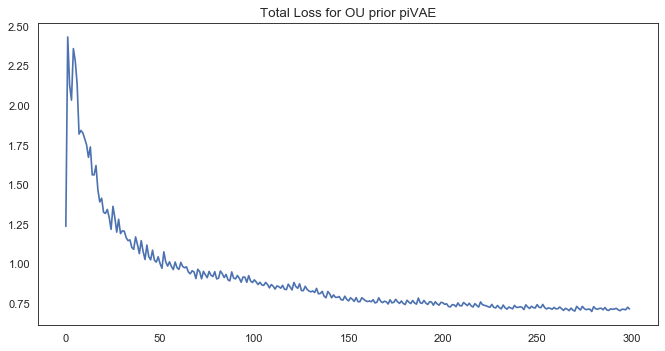

In [34]:
plt.plot(Loss_per_epoch_append)
plt.title("Total Loss for OU prior piVAE" )
plt.show()

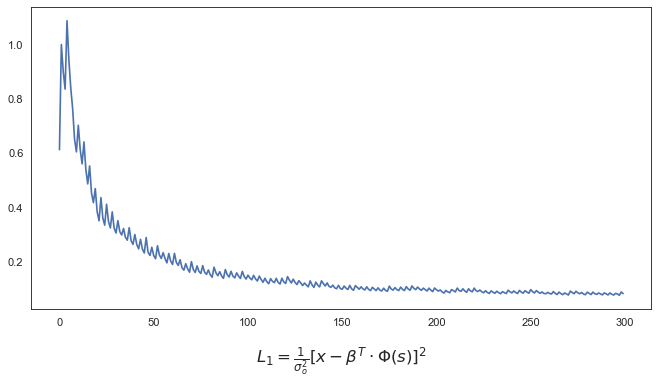

In [40]:
plt.plot(L1_per_epoch_append)
plt.title(r'$L_1=\frac{1}{\sigma_o^2}[x-\beta^T\cdot\Phi(s)]^2}$', fontsize=15, y=-0.2 )
plt.show()

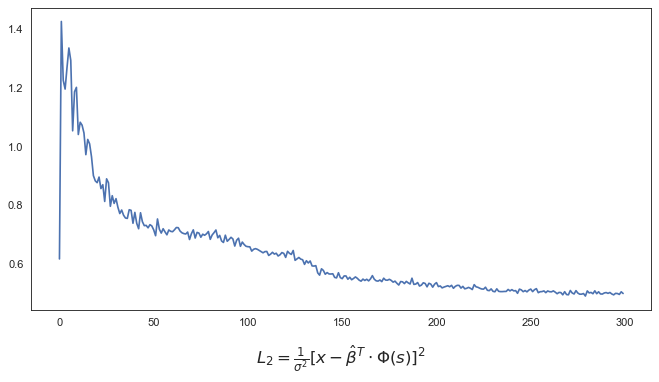

In [39]:
plt.plot(L2_per_epoch_append)
plt.title(r'$L_2=\frac{1}{\sigma^2}[x-\hat\beta^T\cdot\Phi(s)]^2}$', fontsize=15, y=-0.2)
plt.show()

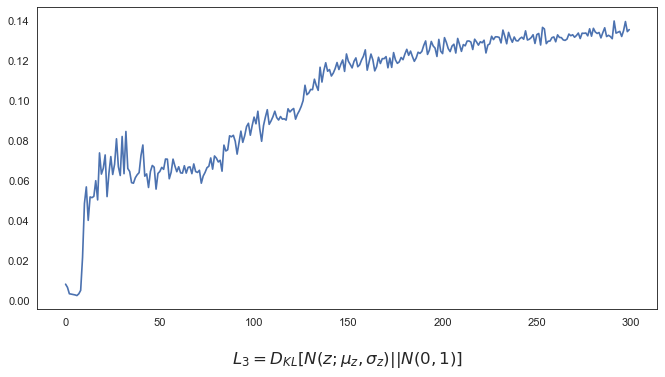

In [41]:
plt.plot(L3_per_epoch_append)
plt.title(r'$L_3=D_{KL}[N(z; \mu_z, \sigma_z)||N(0,1)]$' , fontsize=15, y=-0.2)
plt.show()

### Generate OU samples from piVAE using $z \sim N(0,1):$

In [42]:
num_piVAE_samples=5

In [43]:
test_pts_for_plot_tensor = torch.arange(-5., 5., 0.05).double() 
test_pts_for_plot_tensor.shape    

torch.Size([200])

In [44]:
test_pts_for_plot_np = np.arange(-5., 5., 0.05)
test_pts_for_plot_np.shape    

(200,)

In [45]:
piVAE_samples_tensor = pivae_model.generate_x_samples_from_pivae(
                                test_pts_for_plot_tensor.unsqueeze(1),5)

In [46]:
piVAE_samples_np = np.array(piVAE_samples_tensor.detach().numpy())

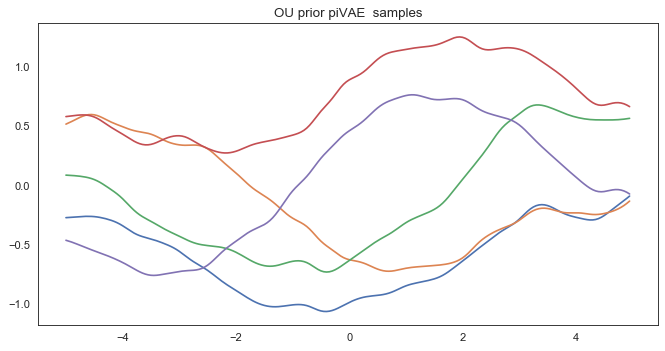

In [47]:
for i in range(piVAE_samples_np.shape[0]):
    plt.plot(test_pts_for_plot_tensor.detach().cpu().numpy(), piVAE_samples_np[i, :])
plt.title("OU prior piVAE  samples")
plt.show()

In [48]:
def plot_decoded_x_samples_from_z_posterior(model, z_samples_from_post, s_star_tensor, x_star_tensor):    
            
    for i in range(z_samples_from_post.shape[0]):
        # Evaluates decoded x at location test_points when the value of the latent z_samples are given
        decoded_x = model.evaluate_decoded_x_at_given_z(z_samples_from_post[i,:],
                                                           test_pts_for_plot_tensor.unsqueeze(1))

        plt.plot(test_pts_for_plot_np, decoded_x.detach().numpy(), alpha=0.1, color='black')

    
    plt.scatter(s_star_tensor.detach().numpy(), x_star_tensor.detach().numpy(), s=1000, marker="+")
    plt.show()

In [49]:
# Compute a quantity proportional to p(z|x, s) where x and s are new test points
def get_unnormalized_log_posterior(model, s, x, z, obs_sigma):        
        
    #z ~ N(0,1)
    log_prior = -0.5 * torch.sum(z**2)

    phi_s = model.Phi(s)

    beta_hat = model.decoder(z)
    
    x_dec = torch.matmul(phi_s, beta_hat.squeeze()) 
    
    x=torch.squeeze(x)
    
    #GAUSSIAN LL 
    log_likelihoods = (-1 / (2 * obs_sigma**2)) * (x_dec - x)**2

    return log_prior + torch.sum(log_likelihoods)

In [50]:
def draw_MCMC_z_samples(model, nbr_z_samples, z_starting_point, MH_proposal_sigma, obs_sigma, s_star_tensor, x_star_tensor):
        
    z = z_starting_point
    #create a tensor of zeros to contain the z values that are going to be sampled
    z_samples = torch.zeros((nbr_z_samples, z_dim)).double()

    acceptance_prob_sum = 0

    for z_sample in range(nbr_z_samples):
        if(z_sample %1000==0):
            print("sample_id",z_sample)
        #z_p ~ N(z,MH_sigma**2)
        z_proposed = z + torch.randn_like(z) * MH_proposal_sigma**2            

        log_posterior_z = get_unnormalized_log_posterior(model, s_star_tensor, 
                                                         x_star_tensor, z, obs_sigma)

        log_posterior_z_proposed = get_unnormalized_log_posterior(model, s_star_tensor, 
                                                                x_star_tensor, z_proposed, obs_sigma)

        MH_ratio = torch.exp(log_posterior_z_proposed - log_posterior_z)

        acceptance_prob = torch.min(torch.tensor(1.0).double(), MH_ratio)

        u = torch.rand(1).double()

        if u < acceptance_prob:
            z = z_proposed

        z_samples[z_sample, :] = z

        acceptance_prob_sum += acceptance_prob.detach()

    print("mean acceptance prob", acceptance_prob_sum/nbr_z_samples)
    return z_samples


In [51]:
ls=1.0
sigma_f=1.0

def ground_truth_OU_function(locations):

    cov = exponential_kernel(locations, locations, ls, sigma_f)
    mu = np.zeros(locations.shape)
        
    OU_sample = np.random.multivariate_normal(mu.ravel(), cov, 1) 
    return OU_sample.T

In summary what needs doing is the following: create a long series of test points of size say 1000. On these points compute x-values of an OU process. Store these 2 series into a dataframe. 
Select 100 points from this df: 100 s locations and their corresponding x values. 
Run MCMC on these 100 points and plot against the true value. 

Then select another 20 points from this same dataframe but which has not been used to run the first posterior. 
Run MCMC to get posterior om these new 20 points. 
Compare the value of the posterior st these new points with their true v alue from the dataframe. 

In [52]:
s_star_np=np.arange(-5.,5,0.1)
s_star_np.shape

(100,)

In [53]:
x_star_np=ground_truth_OU_function(np.expand_dims(s_star_np,1))
x_star_np.shape

(100, 1)

In [54]:
#create a data frame with 2 columns: one for the s_star and one for the x_star
df=pd.DataFrame(s_star_np)
df['x_star']=x_star_np
df['s_star']=s_star_np
#df

In [55]:
#select observations from ground truth
nbr_obs=10
s_obs=np.zeros(nbr_obs)
x_obs=np.zeros(nbr_obs)

k=int(len(s_star_np)/nbr_obs)
print(k)
for i in range(nbr_obs):
    s_obs[i]=df['s_star'][k*i]
    x_obs[i]=df['x_star'][k*i]
s_obs.shape

10


(10,)

In [56]:
#add noise to ground truth
sigma_noise=0.1
epsilon = np.random.normal(loc=0, scale=sigma_noise, size=len(x_obs))
epsilon.shape
y_obs=np.zeros(nbr_obs)
y_obs.shape
y_obs=x_obs +epsilon
y_obs.shape

(10,)

nbr observations: 10


Text(0.5, 1.0, 'Ground truth OU prior and 2 observations')

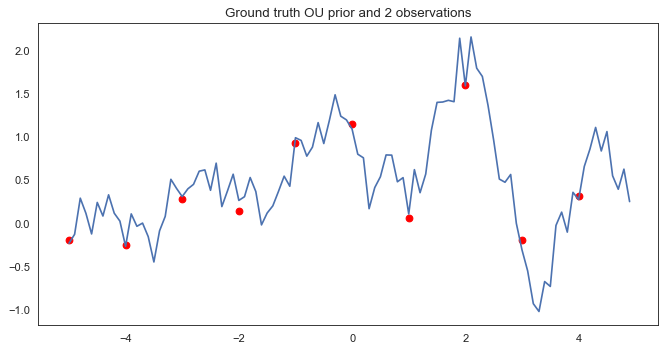

In [57]:
plt.plot(s_star_np, x_star_np, label='Ground truth')
plt.scatter(s_obs, y_obs, color='r')
print("nbr observations:", len(y_obs))
length=len(y_obs)
plt.title('Ground truth OU prior and 2 observations')
#plt.show()

In [58]:
z = torch.ones((z_dim,)).double()

In [63]:
#when MH_proposal_sigma increases the credible interval gets too narrow 
#when obs_sigma decreases: the mean posterior gets closer to the ground truth

nbr_iter=10000
MH_proposal_sigma=0.5
obs_sigma=1.5

mcmc_samples = draw_MCMC_z_samples(pivae_model, nbr_iter, z, MH_proposal_sigma, obs_sigma, torch.tensor(s_obs).unsqueeze(1), 
                                        torch.tensor(y_obs))

sample_id 0
sample_id 1000
sample_id 2000
sample_id 3000
sample_id 4000
sample_id 5000
sample_id 6000
sample_id 7000
sample_id 8000
sample_id 9000
mean acceptance prob tensor(0.5650, dtype=torch.float64)


In [64]:
mcmc_selected_samples_run1 = mcmc_samples[1000::100,:]

In [65]:
mcmc_selected_samples_run1.shape

torch.Size([90, 20])

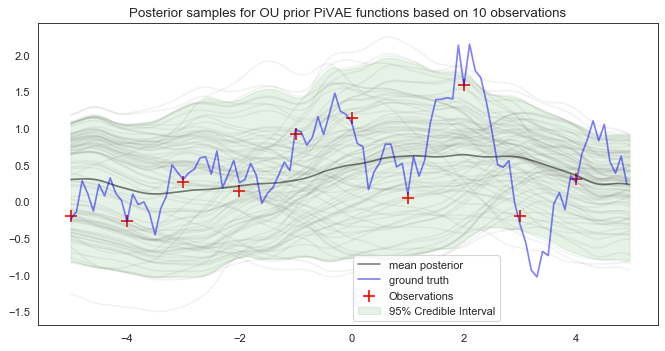

In [71]:
all_dec_x=[]    
for i in range(len(mcmc_selected_samples_run1)):
        
    decoded_x = pivae_model.evaluate_decoded_x_at_given_z(mcmc_selected_samples_run1[i,:], 
                                                             test_pts_for_plot_tensor.unsqueeze(1))
    
    plt.plot(test_pts_for_plot_np, decoded_x.detach().numpy(), alpha=0.1, color='grey')
    
    all_dec_x.append(decoded_x.detach().numpy())  
      
mean_dec_x=np.mean(np.array(all_dec_x), axis=0)

quantile_0975_dec_x=np.quantile(np.array(all_dec_x),0.975,axis=0)

quantile_0025_dec_x=np.quantile(np.array(all_dec_x),0.025,axis=0)
    
plt.plot(test_pts_for_plot_np, mean_dec_x, alpha=0.5, color='k', label='mean posterior')
    
plt.scatter(s_obs, y_obs, color="red", s=100, marker="+", label="Observations")
plt.plot(s_star_np, x_star_np, alpha=0.5, color='b', label="ground truth")

plt.fill_between(test_pts_for_plot_np, quantile_0025_dec_x, quantile_0975_dec_x,
                    facecolor="green",
                    color='green', 
                    alpha=0.1, label = '95% Credible Interval') 

plt.legend(bbox_to_anchor=(0.5,.25))
plt.title("Posterior samples for OU prior PiVAE functions based on 10 observations")
plt.show()

In [72]:
#from the same function that generated 20 observation points, get new points 
#see the value of both Pi-VAE and GP posterior. 
#Compute them against known function and report the RMSE. 

In [73]:
#select 20 new points from the dataframe
nbr_new_star=5
s_obs_20=np.zeros(nbr_new_star)
x_obs_20=np.zeros(nbr_new_star)
for i in range(nbr_new_star):
    s_obs_20[i]=df['s_star'][15*i]
    x_obs_20[i]=df['x_star'][15*i]
x_obs_20.shape

(5,)

Text(0.5, 1.0, 'Ground truth OU prior')

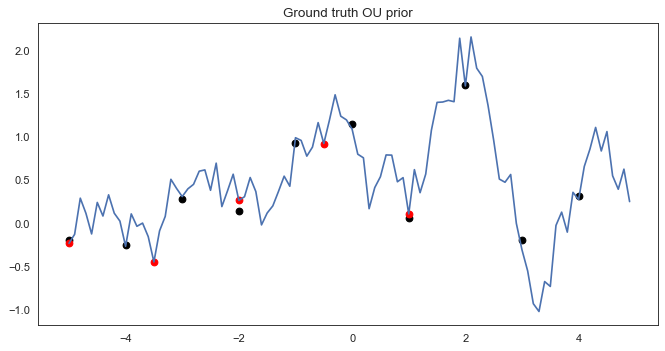

In [74]:
plt.plot(s_star_np, x_star_np, label='Ground truth')
plt.scatter(s_obs, y_obs, color='k')
plt.scatter(s_obs_20, x_obs_20,color="r")
#plt.scatter(s_star_np, y_obs, color='r', label='Noisy Observations')

#plt.legend(loc='upper left', borderaxespad=0.)
plt.title('Ground truth OU prior')
#plt.show()

In [75]:
#now we need to compute the posterior at these 20 new points
#the way to do this is to run MCMC on these samples and take the mean posterior of these samples
nbr_iter_2=10000
mcmc_samples2 = draw_MCMC_z_samples(pivae_model, nbr_iter_2, z, MH_proposal_sigma, obs_sigma, 
                                   torch.tensor(s_obs_20).unsqueeze(1), torch.tensor(x_obs_20))

sample_id 0
sample_id 1000
sample_id 2000
sample_id 3000
sample_id 4000
sample_id 5000
sample_id 6000
sample_id 7000
sample_id 8000
sample_id 9000
mean acceptance prob tensor(0.5731, dtype=torch.float64)


In [76]:
mcmc_selected_samples_run2 = mcmc_samples2[1000::100,:]

In [77]:
mcmc_selected_samples_run2.shape

torch.Size([90, 20])

In [78]:
def eval_decoded_x_at_given_z(model, z, s):        
        phi_s = model.Phi(s)       
        beta_hat = model.decoder(z)        
        x_dec = torch.matmul(phi_s, beta_hat)        
        return x_dec   

In [79]:
all_dec_x=[]    
for i in range(len(mcmc_selected_samples_run2)):
    decoded_new_x = eval_decoded_x_at_given_z(pivae_model, mcmc_selected_samples_run2[i,:], 
                                                             torch.tensor(s_obs_20).unsqueeze(1))

    all_dec_x.append(decoded_new_x.detach().numpy())  
      
new_star_mean_post=np.mean(np.array(all_dec_x), axis=0)
new_star_mean_post.shape

(5,)

In [80]:
#nbr_new_star=5
RMSE=np.sqrt(np.sum((new_star_mean_post - x_obs_20)**2/nbr_new_star))
RMSE

0.4519435522295068

In [ ]:
def check_beta(model, id):
    
    test_points = torch.arange(-5, 5, 0.01).reshape(1000, 1)
    
    phi_s = model.Phi(test_points)
    
    beta = model.betas[id, :]
    
    x_encs = torch.matmul(phi_s, beta)
    
    z_mean, z_std = model.encoder(beta.unsqueeze(0))
    
    beta_hat = model.decoder(z_mean)
    
    x_decs = torch.matmul(beta_hat, torch.transpose(phi_s, 0, 1))
    
    #plot encoded x's against test locations
    plt.plot(test_points.detach().cpu().numpy(), x_encs.detach().cpu().numpy(), color='red')
    
    #plot decoded x's against test locations
    plt.plot(test_points.detach().cpu().numpy().reshape(1000), x_decs.detach().cpu().numpy().reshape(1000), color='green')
    
    plt.scatter(dataset_loc_training[id].reshape(K), dataset_OU_training[id].reshape(K))
    plt.title("Reconstruction of training data")
    plt.show()

In [ ]:
# ------ Check reconstructions of training data -------
for i in range(10):
    check_beta(pivae_model, i)

#%%